Model orthogonalization with LDM variants (heavily based on Vojta's original code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good models 10 bad models
* 1 pefect model, 3 good models, 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants: Data preparation
    └── PCA - Analysis

        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [51]:
pip install corner 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import corner 



#Some colors that Pablo likes:
colors = [
    "#ff7f0e",

    "#1f77b4",

    "#2ca02c",
    "#d62728",
    
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 

markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]
def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

# def data_loader():
#     #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
#     input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
#     input_NZ.columns = ["N", "Z"]
#     return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return


def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Load NZ
# input_NZ =  data_loader()


### Global variables####

# SkO values selected for the truth

truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 
GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1
BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]



# NL_1 
TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57]



#Noise terms to be added to the observations (masses)
noise_term_p=0.01
noise_term_g=0.05
noise_term_b=0.05
noise_term_t=0.05





#Noise terms to be added to the parameters


params_noise_term_p=0.000
params_noise_term_g=0.002
params_noise_term_b=0.002
params_noise_term_t=0.002

overall_output_noise=0.01

##########################


#Number used for when dividing training and testing randomly uniformly (interpolating)
TestingFraction=0.34

#Number used for when dividing training and testing by how close they are to the stable nuclei
distance=3



#Target nucleus: Calcium 60
target_isotope=np.array([40,20])

In [2]:
def separate_points_random(list1,random_chance):
    """
    Separates points in list1 into two groups randomly

    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]


    for i in range(len(list1)):
        point1=list1[i]
        val=np.random.rand()
        if val<=random_chance:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [3]:
def separate_points_distance(list1, list2, distance):
    """
    Separates points in list1 into two groups based on their proximity to any point in list2.

    :param list1: List of (x, y) tuples.
    :param list2: List of (x, y) tuples.
    :param distance: The threshold distance to determine proximity.
    :return: Two lists - close_points and distant_points.
    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]

    for i in range(len(list1)):
        point1=list1[i]
        close = False
        for point2 in list2:
            if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance:
                close = True
                break
        if close:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [4]:
stable_coordinates=np.loadtxt("StableIsotopes.txt")

In [5]:
Full_set=np.loadtxt("NZ_even_even.txt")

In [6]:
#Separating randomly
np.random.seed(142857)
training_set, testing_set, train_coordinates, test_coordinates=separate_points_random(Full_set, TestingFraction)


In [7]:
#Separating using the proximity to the stable isotopes

training_set, testing_set, train_coordinates, test_coordinates=separate_points_distance(Full_set, stable_coordinates, 3)

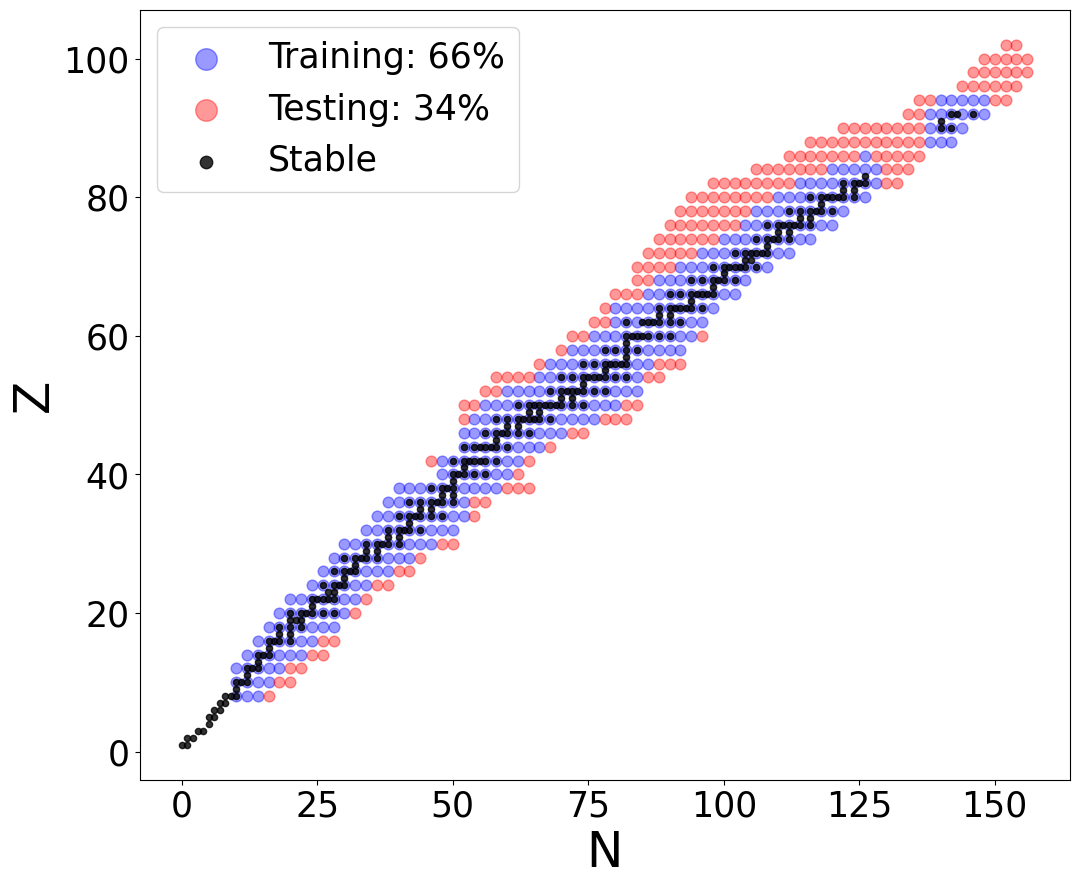

In [8]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

ax.scatter(x = training_set.T[0], y = training_set.T[1], label = "Training: " + str(round(len(training_set)/len(Full_set)*100))+"%", alpha = 0.4,color="blue",s=60)



ax.scatter(x = testing_set.T[0], y = testing_set.T[1], label = "Testing: " + str(round(len(testing_set)/len(Full_set)*100))+"%", alpha = 0.4,color='red',s=60)

ax.scatter(x = stable_coordinates.T[0], y = stable_coordinates.T[1], label = "Stable", alpha = 0.8,color='black',s=20)



plt.xlabel("N",fontsize=35)
plt.ylabel("Z",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.show()

In [9]:

# scenario = "1g1b"
# scenario = "3g10b"
# scenario = "1p3g10b"
# Fix random seed
np.random.seed(142857)
n_perfect =1
n_good = 3
n_bad = 5
n_terrible=10

n_classes=[n_perfect,n_good,n_bad,n_terrible]
n_Labels=["Perfect Model", "Good Models", "Interm. Models","Bad Models"]







# masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 

models_output = {}
models_output_train = {}
models_output_test = {}

# models_output_target={}
models_output_target=[]






# #Option 1: Constructing the data by adding a random noise to the output of the models
# #Perfect Models Loop
# params = PerfectM_params
# for i in range(n_perfect):
#     models_output[str("PerfectModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_p


# #Good Models Loop
# params = GoodM_params
# for i in range(n_good):
#     models_output[str("GoodModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_g

# #Bad Models Loop
# params = BadM_params
# for i in range(n_bad):
#     models_output[str("IntermediateModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_b

# #Terrible Models Loop
# params = TerribleM_params
# for i in range(n_terrible):
#     models_output[str("BadModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_t






#Option 2: Constructing the data by adding a random noise to the parameters of the models
#Perfect Models Loop
params = PerfectM_params
for i in range(n_perfect):
    ran_params=params + np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_p
    models_output[str("PerfectModel_")+str(i)] = LDM_extended(ran_params
                                                              ,Full_set.T)
    + np.random.normal(0,1,size=len(Full_set)) * overall_output_noise


    # models_output_target[str("PerfectModel_")+str(i)] = LDM_extended(ran_params
    #                                                           ,target_isotope)
    models_output_target.append(LDM_extended(ran_params
                                                              ,target_isotope))
    

#Good Models Loop
params = GoodM_params
for i in range(n_good):

    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_g
    models_output[str("GoodModel_")+str(i)] = LDM_extended(ran_params
                                                           ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    # models_output_target[str("GoodModel_")+str(i)] = LDM_extended(ran_params ,target_isotope)
    models_output_target.append(LDM_extended(ran_params ,target_isotope))


#Bad Models Loop
params = BadM_params
for i in range(n_bad):
    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_b
    models_output[str("IntermediateModel_")+str(i)] = LDM_extended(ran_params
                                                                   ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    
    # models_output_target[str("IntermediateModel_")+str(i)] = LDM_extended(ran_params ,target_isotope)
    models_output_target.append(LDM_extended(ran_params ,target_isotope))
    



#Terrible Models Loop
params = TerribleM_params
for i in range(n_terrible):
    ran_params=params+ np.random.normal(0,1,size=len(truth_params))*truth_params*params_noise_term_t
    models_output[str("BadModel_")+str(i)] = LDM_extended(ran_params
                                                          ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    
    # models_output_target[str("BadModel_")+str(i)] = LDM_extended(ran_params,target_isotope)
    models_output_target.append(LDM_extended(ran_params,target_isotope))
















#This is done here to have a list of pure models, without the ground truth
key_list=list(models_output.keys())

models_output['truth']=LDM_extended(truth_params,Full_set.T) 


models_output = pd.DataFrame(models_output)
models_output["N"] = Full_set.T[0]
models_output["Z"] = Full_set.T[1]
models_output["A"] = models_output["N"] + models_output["Z"]

models_output_target=np.array(models_output_target)
models_output_target_mean=np.mean(models_output_target)

In [10]:

models_output_train = models_output.iloc[train_coordinates]

models_output_test = models_output.iloc[test_coordinates]

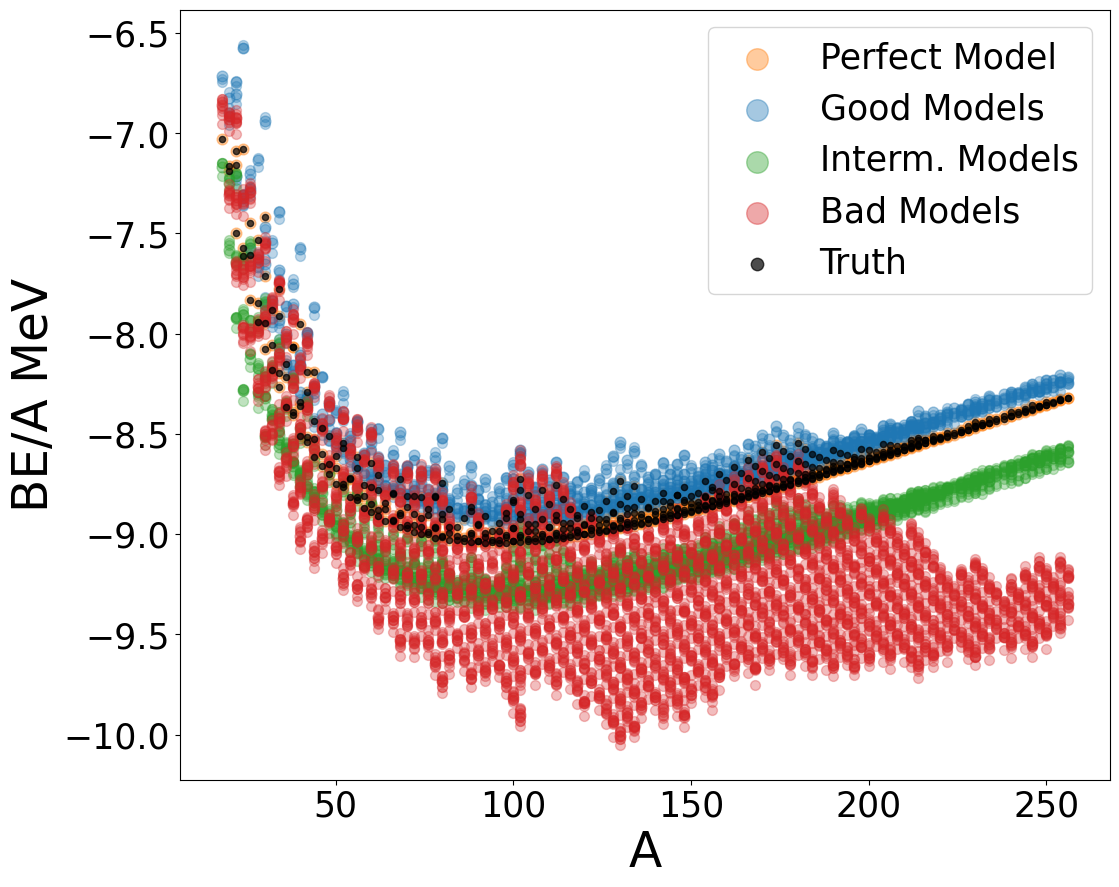

In [11]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output["A"], y = models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )

plt.show()

In [12]:
key_list

['PerfectModel_0',
 'GoodModel_0',
 'GoodModel_1',
 'GoodModel_2',
 'IntermediateModel_0',
 'IntermediateModel_1',
 'IntermediateModel_2',
 'IntermediateModel_3',
 'IntermediateModel_4',
 'BadModel_0',
 'BadModel_1',
 'BadModel_2',
 'BadModel_3',
 'BadModel_4',
 'BadModel_5',
 'BadModel_6',
 'BadModel_7',
 'BadModel_8',
 'BadModel_9']

In [13]:
residuals = models_output['truth'].values[:,None] - models_output[key_list].values 

residuals_train = models_output_train['truth'].values[:,None] - models_output_train[key_list].values 

residualss_test  = models_output_test['truth'].values[:,None] - models_output_test[key_list].values 



model_predictions=models_output[key_list].values
model_predictions_train=models_output_train[key_list].values
model_predictions_test=models_output_test[key_list].values






model_summary = {}
# model_summary["mean"] = models_output[models_output.keys()].mean(axis = 0).values
# model_summary["std"] = models_output[models_output.keys()].std(axis = 0).values
# model_summary["res_mean"] = residuals.mean(axis = 0)
# model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse_all"] = np.sqrt(np.mean(residuals ** 2, axis = 0))
model_summary["rmse_train"] = np.sqrt(np.mean(residuals_train ** 2, axis = 0))
model_summary["rmse_test"] = np.sqrt(np.mean(residualss_test ** 2, axis = 0))


model_summary_df = pd.DataFrame(model_summary, index =key_list)
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                     rmse_all  rmse_train  rmse_test
PerfectModel_0       0.000000    0.000000   0.000000
GoodModel_0          0.147066    0.149089   0.142982
GoodModel_1          0.121387    0.121539   0.121085
GoodModel_2          0.145008    0.146541   0.141928
IntermediateModel_0  0.309478    0.287618   0.348688
IntermediateModel_1  0.285162    0.260701   0.328203
IntermediateModel_2  0.345990    0.323120   0.387252
IntermediateModel_3  0.287810    0.263889   0.330040
IntermediateModel_4  0.280497    0.257113   0.321768
BadModel_0           0.596602    0.551470   0.677037
BadModel_1           0.600722    0.555260   0.681741
BadModel_2           0.608733    0.563316   0.689783
BadModel_3           0.600082    0.554332   0.681556
BadModel_4           0.562217    0.517568   0.641413
BadModel_5           0.586735    0.541980   0.666436
BadModel_6           0.579493    0.534989   0.658692
BadModel_7           0.607086    0.561946   0.687669
BadModel_8           0.582905    0.538265   0.

In [14]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output[(models_output['Z'] >= Z_range[0]) & (models_output['Z'] <= Z_range[1]) & 
                     (models_output['N'] >= N_range[0]) & (models_output['N'] <= N_range[1])]

filtered_models_output_test = models_output_test[(models_output_test['Z'] >= Z_range[0]) & (models_output_test['Z'] <= Z_range[1]) & 
                     (models_output_test['N'] >= N_range[0]) & (models_output_test['N'] <= N_range[1])]


filtered_models_output_train = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'] >= N_range[0]) & (models_output_train['N'] <= N_range[1])]

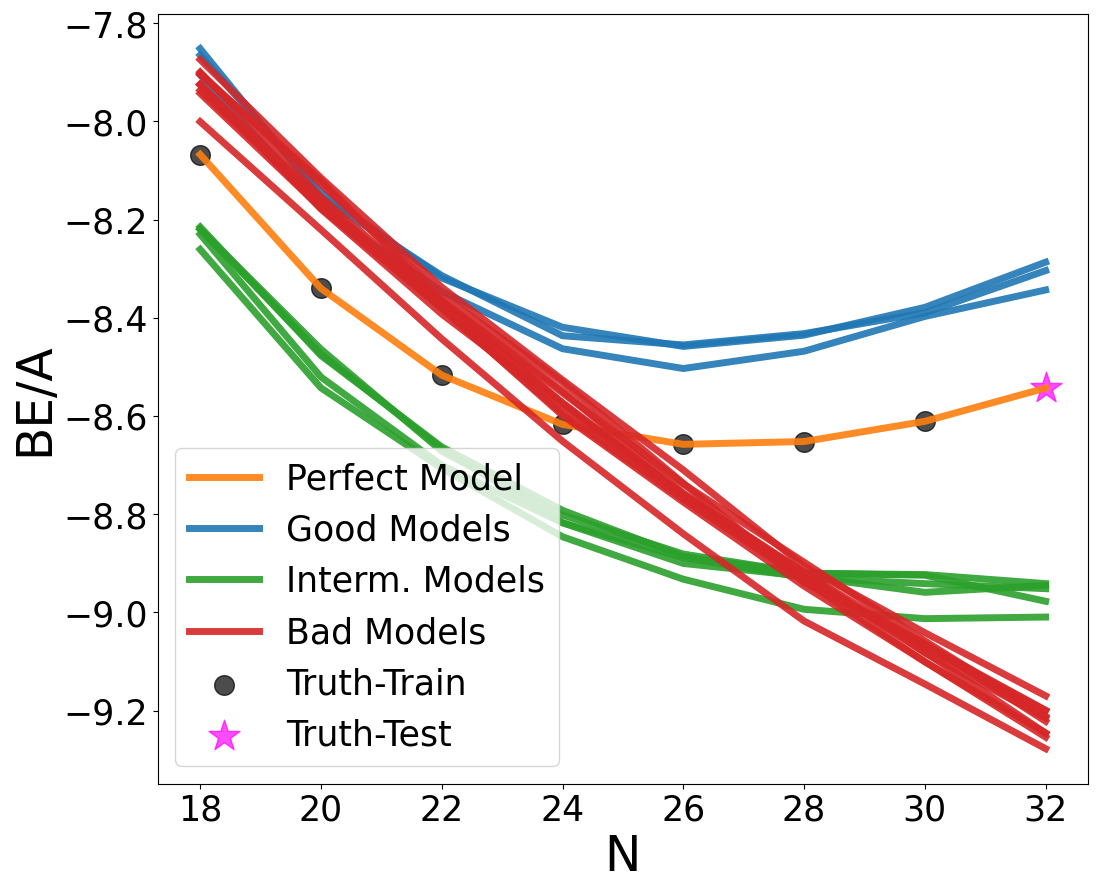

In [15]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth-Train", alpha = 0.7,color='k',s=200)
ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'], label = "Truth-Test", alpha = 0.7,color='magenta',s=550,marker="*")


plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=1 )

plt.show()

In [16]:
np.shape(model_predictions_train)

(346, 19)

## PCA - Analysis (with centering)

In [17]:
predictions_mean= np.mean(model_predictions, axis=1)
predictions_train_mean= np.mean(model_predictions_train, axis=1)
predictions_test_mean= np.mean(model_predictions_test, axis=1)

In [18]:
model_predictions_train_centered=np.array([model_predictions_train.T[j]-predictions_train_mean for j in range(len(model_predictions_train.T))]).T

In [19]:
U, S, Vt = np.linalg.svd(model_predictions_train_centered)

In [20]:
S

array([2.02399752e+01, 7.05326194e+00, 5.60183315e-01, 3.75001821e-01,
       2.13689705e-01, 2.07856066e-01, 2.02252317e-01, 1.97691513e-01,
       1.93719151e-01, 1.88306150e-01, 1.82029215e-01, 1.76765635e-01,
       1.75380581e-01, 1.68680707e-01, 1.65140911e-01, 1.55646280e-01,
       1.51770904e-01, 1.45962886e-01, 9.78154778e-14])

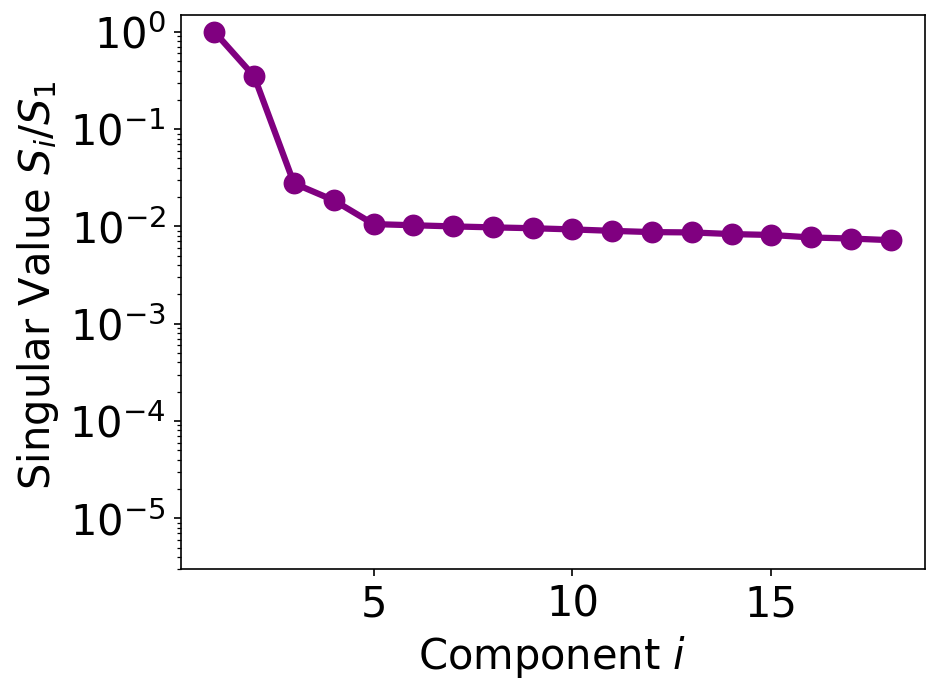

In [21]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(1,S.size), S[0:-1]/S[0],color='purple',s=90)
ax.plot(np.arange(1,S.size), S[0:-1]/S[0],color='purple',linewidth=3)

ax.set_yscale('log')
ax.set_xlabel(r'Component $i$',fontsize=20)
ax.set_ylabel(r' Singular Value $S_i/S_1$',fontsize=20);
plt.ylim(3*10**(-6),1.5)
# plt.title("Singular values decay",fontsize=30)
plt.show()

In [53]:
components_kept=18
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


In [54]:
#Creating principal components that are valid everywhere (testing + training)
models_PC = {}
models_PC[str("PC_0")] = predictions_mean
for i in range(components_kept):
    # models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)*S_hat[i]
    models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)

models_PC = pd.DataFrame(models_PC)
models_PC["N"] = Full_set.T[0]
models_PC["Z"] = Full_set.T[1]
models_PC["A"] = models_PC["N"] + models_PC["Z"]

In [55]:
#Creating principal components that are for testing



models_PC_testing = {}


models_PC_testing[str("PC_0")] = predictions_test_mean
for i in range(components_kept):
    # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
    models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

models_PC_testing["N"] = models_output_test["N"]
models_PC_testing["Z"] = models_output_test["Z"]
models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]

models_PC_testing = pd.DataFrame(models_PC_testing)






In [56]:
filtered_models_PC = models_PC[(models_PC['Z'] >= Z_range[0]) & (models_PC['Z'] <= Z_range[1]) & 
                     (models_PC['N'] >= N_range[0]) & (models_PC['N'] <= N_range[1])]

In [57]:
key_list_PCs=list(filtered_models_PC.keys())

IndexError: list index out of range

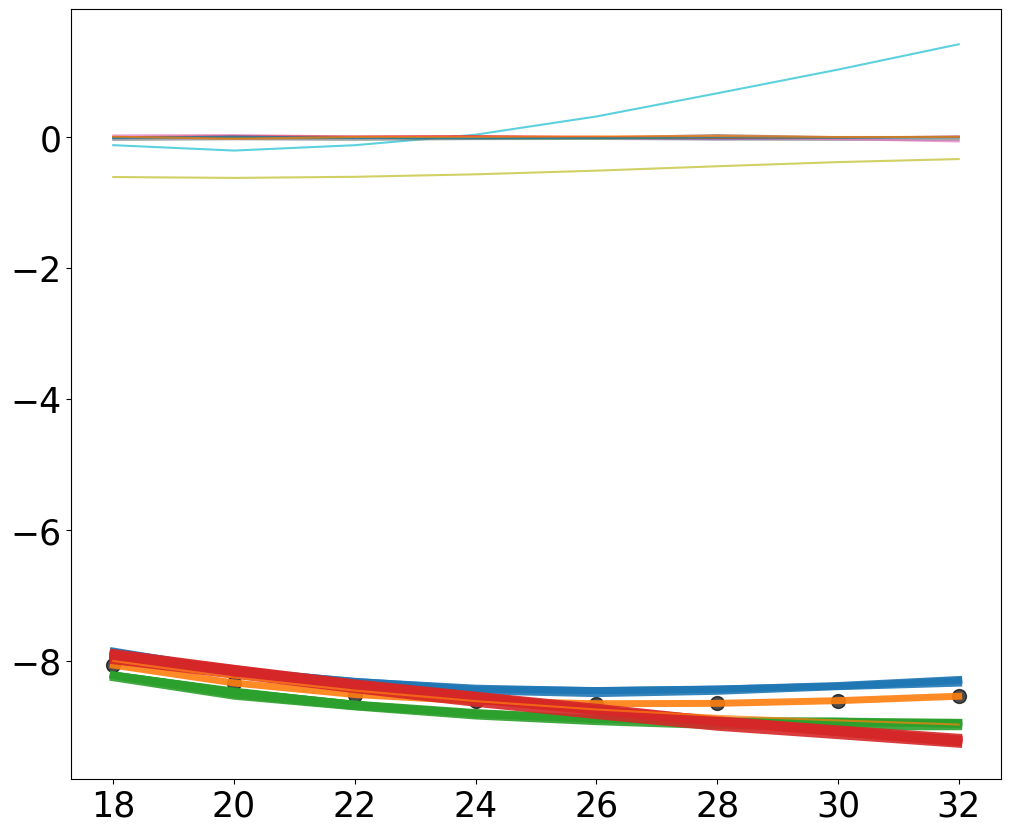

In [58]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0







ax.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=100)

for i in range(components_kept+1):
    ax.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])






plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )

plt.show()

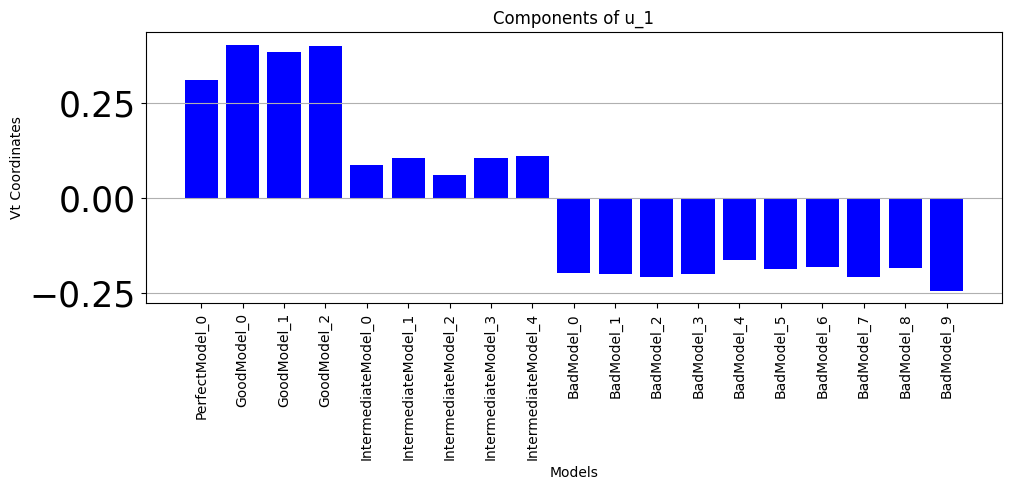

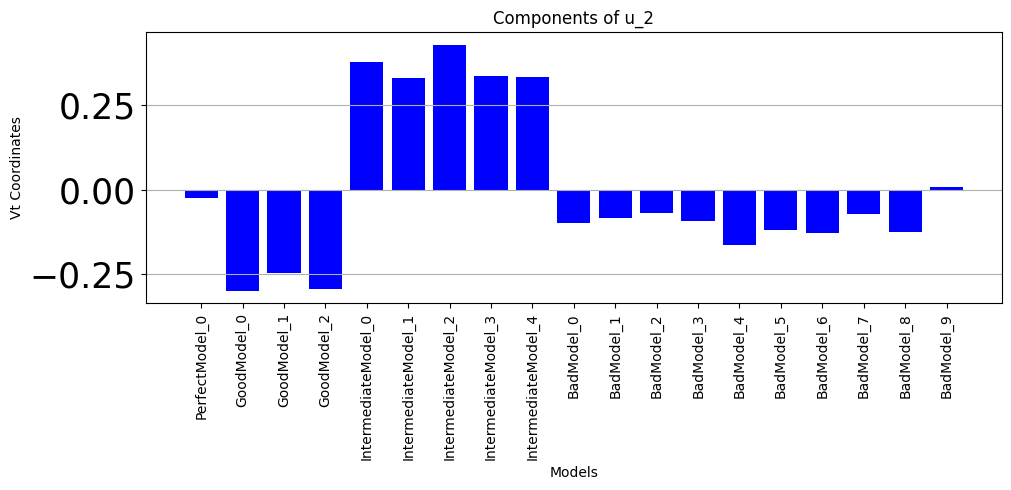

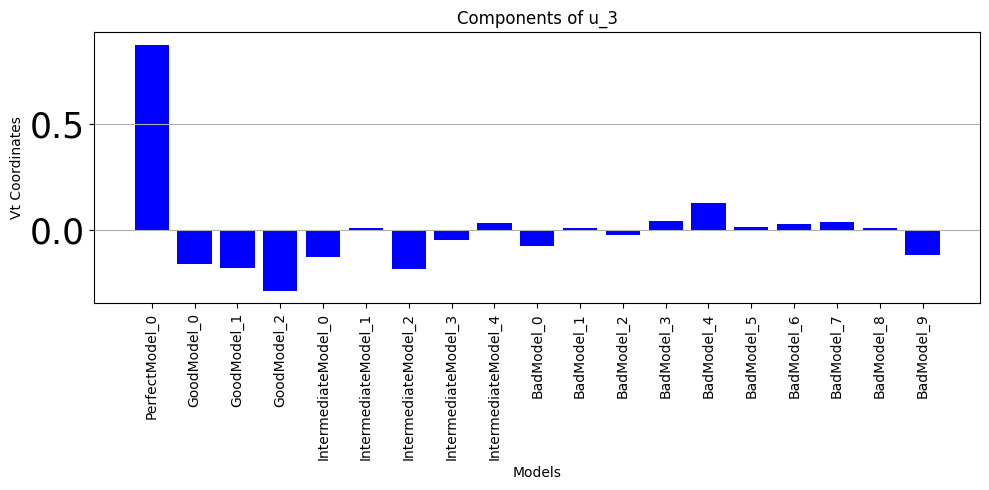

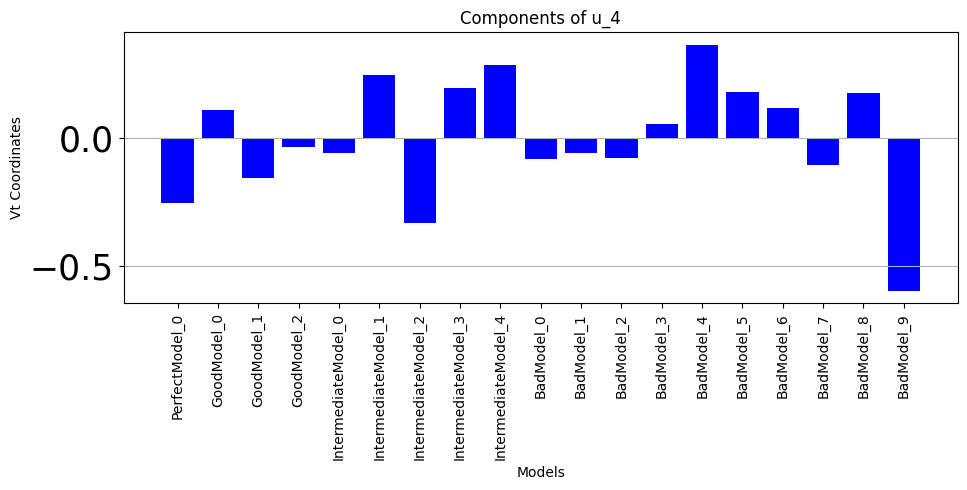

In [ ]:


for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], key_list, title=f"Components of u_{i+1}", color='blue')

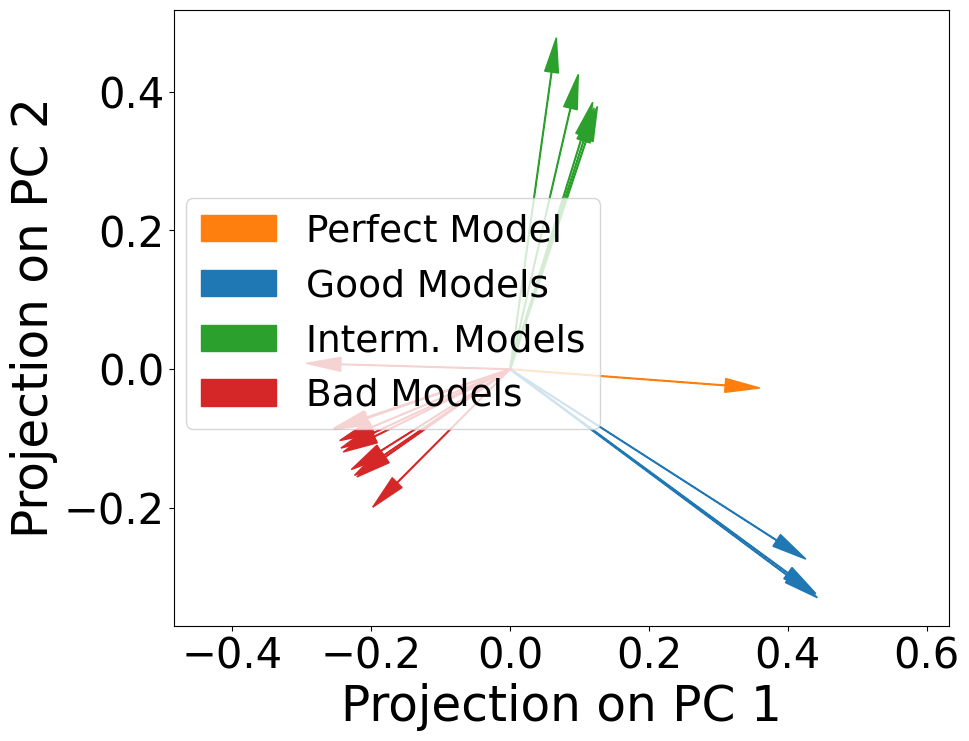

In [ ]:

plt.rc("xtick", labelsize=30)
plt.rc("ytick", labelsize=30)

fig, ax = plt.subplots(figsize=(10,8), dpi=100)

model_index=0
class_index=0

visited_model=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1

            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
           
        else:
            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
        model_index=model_index+1
        visited_model=visited_model+1
    class_index=class_index+1
    legend_flag=0


# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC 1',fontsize=35)
plt.ylabel('Projection on PC 2',fontsize=35)

plt.legend(loc=(0.015, 0.32),fontsize=27)

plt.axis('equal')

plt.show()


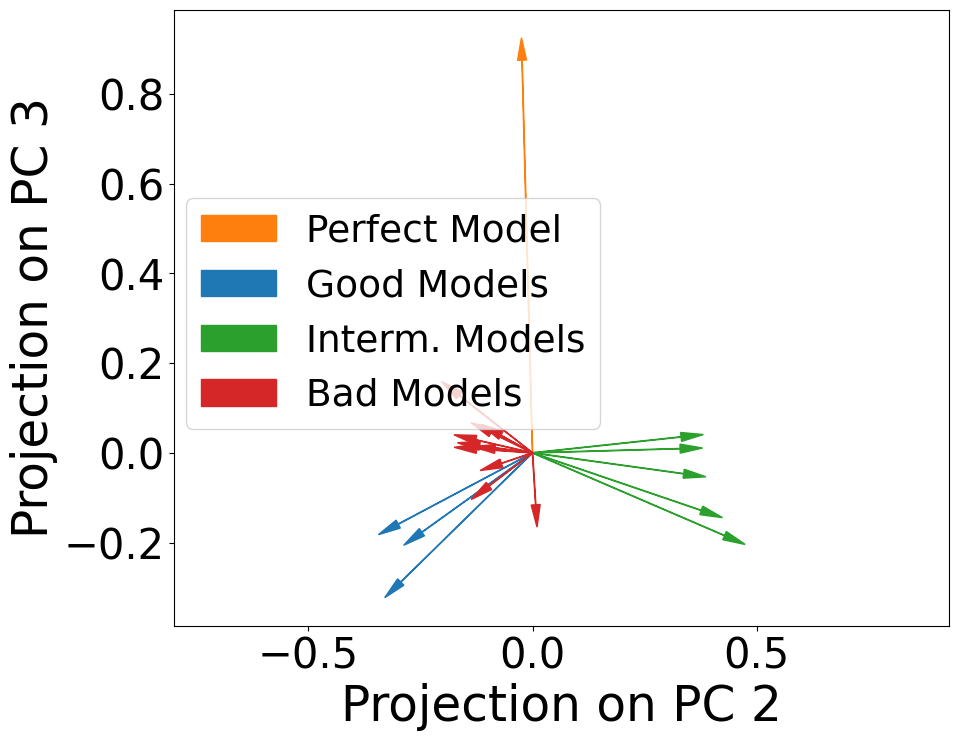

In [ ]:

if components_kept>2:

    plt.rc("xtick", labelsize=30)
    plt.rc("ytick", labelsize=30)

    fig, ax = plt.subplots(figsize=(10,8), dpi=100)

    model_index=0
    class_index=0

    visited_model=0
    for n_vals in n_classes:
        legend_flag=0
        for i in range(n_vals):
            if legend_flag==0:
                legend_flag=1

                plt.arrow(0, 0, Vt_hat.T[visited_model][1], Vt_hat.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
            
            else:
                plt.arrow(0, 0, Vt_hat.T[visited_model][1], Vt_hat.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
            model_index=model_index+1
            visited_model=visited_model+1
        class_index=class_index+1
        legend_flag=0


    # Determine plot limits based on the maximum absolute values of the vectors
    # max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
    # plt.xlim(-max_val-1, max_val+1)
    # plt.ylim(-max_val-1, max_val+1)

    plt.xlabel('Projection on PC 2',fontsize=35)
    plt.ylabel('Projection on PC 3',fontsize=35)

    plt.legend(loc=(0.015, 0.32),fontsize=27)

    plt.axis('equal')

    plt.show()


In [89]:
X=np.copy(U_hat)
y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean

In [90]:
#Making the list of principal components across the entire chart (training+testing)
X_full=[]
for i in range(components_kept+1):
    X_full.append(models_PC[key_list_PCs[i]].tolist())
X_full=np.array(X_full)

In [91]:
#Making the list of principal components across the testing part
X_test=[]
for i in range(components_kept+1):
    X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
X_test=np.array(X_test)

In [92]:
# 1) Find the least square solution for the training part
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

#1.5) Construct the super model across the entire range and the test range
beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
supermodel_full=X_full.T.dot(beta_full)
supermodel_test=X_test.T.dot(beta_full)


# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=500000)


In [93]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(samples,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

: 

In [62]:
# # 4) Make a corner plot in the space of the original models
# samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


# figure = corner.corner(samples_original_space, bins=50, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 20})
# # figure = corner.corner(samples_original_space)

# plt.show()


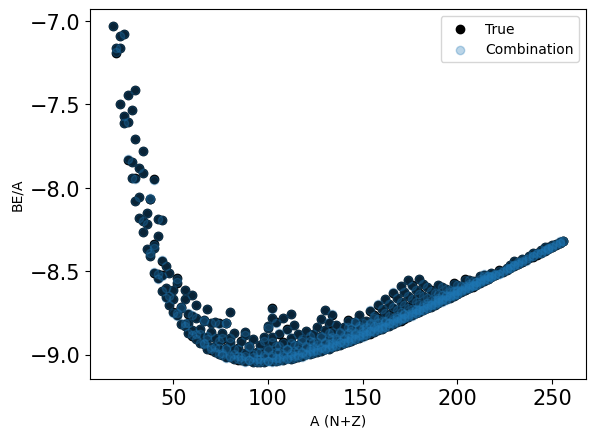

In [63]:
# for key in models_output.keys():
#     plt.scatter(x = models_output["A"], y = models_output[key], label = key, alpha = 0.3)


plt.scatter(x = models_output["A"], y = models_output['truth'], label = str("True"), color='k')



# for key in models_output.keys():
#     plt.scatter(x = models_output["A"], y = models_output[key], label = key, alpha = 0.5)
# # 


# # for i in range(components_kept):
# plt.scatter(x = models_output["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
# plt.scatter(x = models_output["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)
# for i in range(components_kept+1):
#     ax.plot(models_PC["A"], models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])


# plt.scatter(x = models_output["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output["A"], y = supermodel_full, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [64]:
#Restricting the super model to plot on the selected isotope (Calcium)
X_full_filtered=[]

for i in range(len(X_full)):
    X_full_filtered.append(X_full[i][filtered_models_output.index])
X_full_filtered=np.array(X_full_filtered)

In [80]:
samples

array([[ 0.30968916, -0.02311579,  0.87044932, -0.25017081],
       [ 0.30962945, -0.02318767,  0.873141  , -0.25284687],
       [ 0.30967937, -0.02303257,  0.88020871, -0.25729792],
       ...,
       [ 0.30978591, -0.02314241,  0.87861559, -0.25695668],
       [ 0.30963017, -0.02327389,  0.87607814, -0.24651947],
       [ 0.30972961, -0.02349195,  0.87415606, -0.25077593]])

In [65]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand[i], 0, 1))
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(yvals_rand)
                       ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * sigma_squared ) )))   

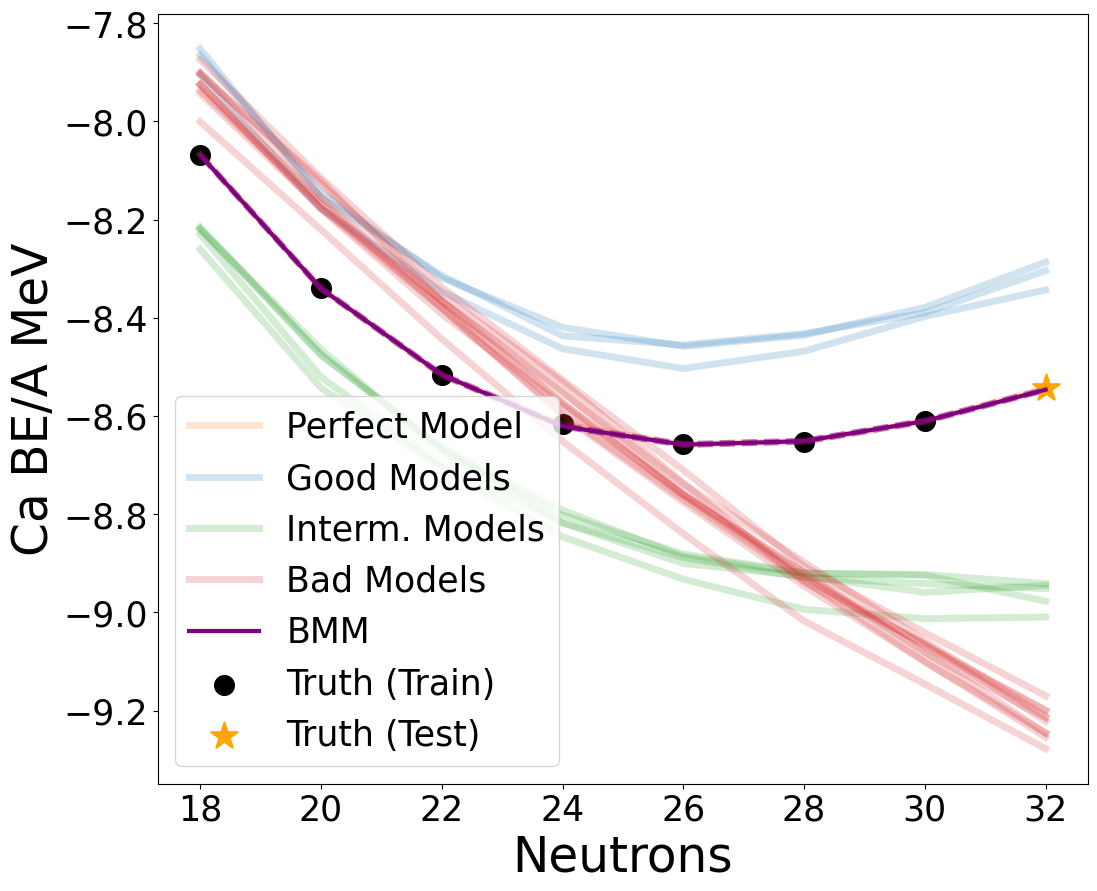

In [66]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

alpha_models=0.2

model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = alpha_models,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0







mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='BMM',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2)





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth (Train)",color='k',s=200)
ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'],
            label = "Truth (Test)",color='orange',s=400,marker="*",edgecolor='face', linewidth=1.5,alpha=1)








plt.xlabel("Neutrons",fontsize=35)
plt.ylabel("Ca BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=1 )

plt.show()

In [67]:
super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()

In [68]:
sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )

In [77]:
sigma_test

0.0014471746682372215

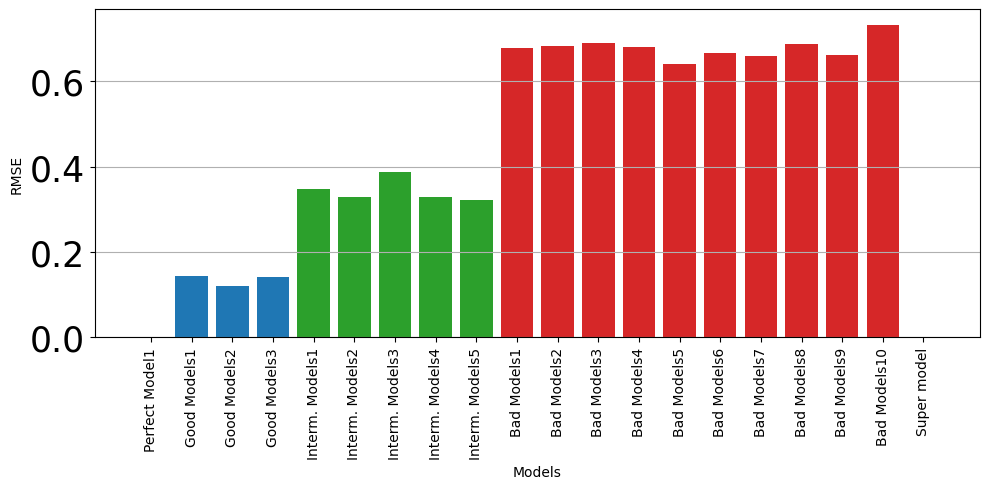

In [70]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))

rmse=[]

model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        # ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], 
        #         label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_test"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_test"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse.append(rmse_av/n_vals)
    class_index=class_index+1




# plt.bar(labels[0:1] , model_summary["rmse_test"][0:1], color='b')

# plt.bar(labels[1:] , model_summary["rmse_test"][1:], color='r')

plt.bar('Super model' , sigma_test, color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [78]:
rmse

[0.0, 0.13533174179008334, 0.3431900980695254, 0.6779561267514007]

In [72]:
def PC_RMSE_calculator(components_kept):

    S_hat=np.array([S[i] for i in range(components_kept)])

    U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])

    Vt_hat=np.array([Vt[i] for i in range(components_kept)])

    

    models_PC_testing = {}


    models_PC_testing[str("PC_0")] = predictions_test_mean
    for i in range(components_kept):
        models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

    models_PC_testing["N"] = models_output_test["N"]
    models_PC_testing["Z"] = models_output_test["Z"]
    models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]

    models_PC_testing = pd.DataFrame(models_PC_testing)

    key_list_PCs=list(models_PC_testing.keys())


    X=np.copy(U_hat)
    y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean



    #Making the list of principal components across the testing part
    X_test=[]
    for i in range(components_kept+1):
        X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
    X_test=np.array(X_test)

    X_T_X_inv = np.linalg.inv(X.dot(X.T))
    beta = X_T_X_inv.dot(X).dot(y)
    supermodel=X.T.dot(beta)


    beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
    supermodel_test=X_test.T.dot(beta_full)

    
    # 2) Construct the covariance matrix
    residuals = y - supermodel
    sigma_squared = np.sum(residuals**2) / len(residuals) 
    

    super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()


    sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )

    return [np.sqrt(sigma_squared),sigma_test]

In [73]:
PC_RMSE_calculator(19)

[9.884685591504991e-17, 9.072252899564294]

In [74]:
s_test=[]
s_train=[]

for i in range(1,19):
    res=PC_RMSE_calculator(i)
    s_train.append(res[0])
    s_test.append(res[1])

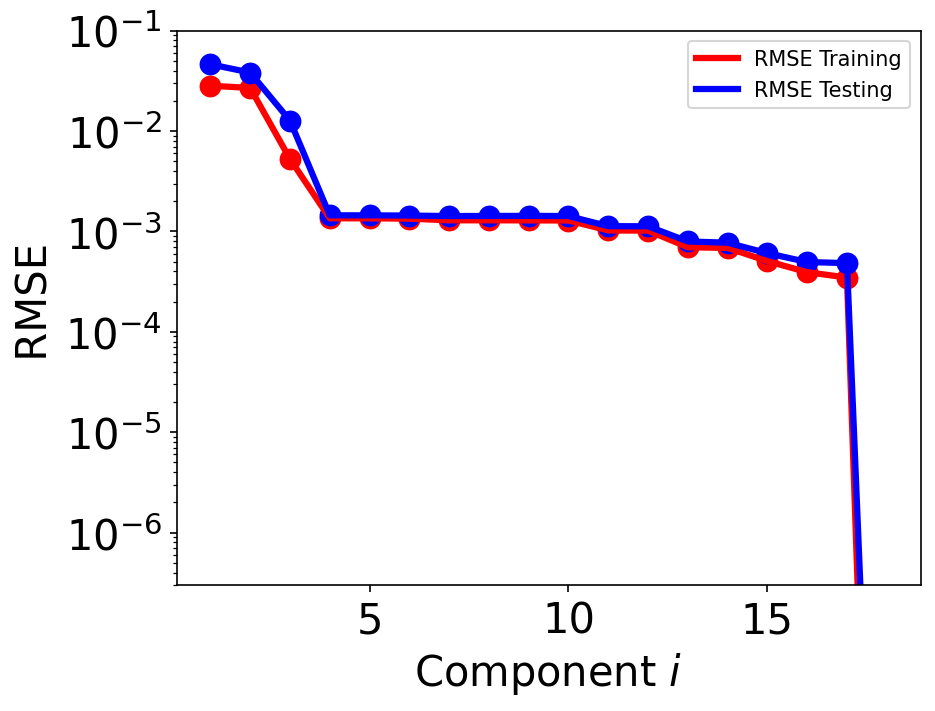

In [75]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')


ax.scatter(np.arange(1,len(s_train)+1), s_train,color='red',s=90)
ax.plot(np.arange(1,len(s_train)+1), s_train,color='red',linewidth=3,label="RMSE Training")


ax.scatter(np.arange(1,len(s_test)+1), s_test,color='blue',s=90)
ax.plot(np.arange(1,len(s_test)+1), s_test,color='blue',linewidth=3,label="RMSE Testing")


ax.set_yscale('log')
ax.set_xlabel(r'Component $i$',fontsize=20)
ax.set_ylabel(r' RMSE',fontsize=20);
plt.ylim(3*10**(-7),0.1)
# plt.title("Singular values decay",fontsize=30)
plt.legend()
plt.show()

In [79]:
theta_rand

array([[ 0.30986126, -0.02329471,  0.87364975, -0.25066784],
       [ 0.30975387, -0.02310434,  0.87275947, -0.25515908],
       [ 0.30969588, -0.02333056,  0.87487616, -0.25251563],
       ...,
       [ 0.30975994, -0.02311471,  0.87533315, -0.25315546],
       [ 0.30970061, -0.02374552,  0.8802138 , -0.25187127],
       [ 0.30972361, -0.02341423,  0.87431734, -0.25405287]])

In [76]:
target_predictions=[]

for i in range(len(theta_rand)):

    coeffs=theta_rand[i].dot(Vt_hat)

    # target_predictions.append(coeffs)
    target_predictions.append(coeffs.dot(models_output_target) + models_output_target_mean)
    

target_predictions=np.array(target_predictions)

ValueError: shapes (4,) and (18,19) not aligned: 4 (dim 0) != 18 (dim 0)

In [ ]:
target_predictions

array([-8.12014735, -8.12046489, -8.11984854, ..., -8.12063151,
       -8.11872877, -8.11890336])

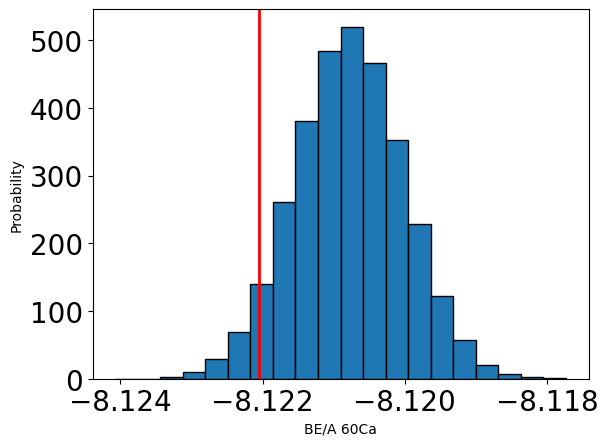

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example NumPy array (replace this with your actual data)
data = np.random.randn(100)  # Generating 100 random data points

# True value 
true_value = LDM_extended(truth_params,target_isotope) 

# Creating the histogram
plt.hist(target_predictions, bins=20, edgecolor='black', density=True)

# Adding a vertical line at the true value
plt.axvline(true_value, color='red', linewidth=2)

# Adding titles and labels (optional)

plt.xlabel('BE/A 60Ca')
plt.ylabel('Probability')

# Display the plot
plt.show()